# SEP 740 - Assignment 2

In the previous assignment, you applied your knowledge of deep learning and implemented a fully connected neural network to classify images from the MNIST dataset. Now, in this assignment, we aim to take things a step further by exploring Convolutional Neural Networks (CNNs), a popular and powerful architecture for image classification tasks.

CNNs are particularly well-suited for image classification problems as they are designed to process data with a grid-like topology. They use convolutional layers to extract meaningful features from images and pooling layers to down-sample the feature maps to reduce their dimensionality. This allows CNNs to learn hierarchical representations of the input data and make robust predictions.

In this assignment, you will build and train a CNN to classify images from the MNIST dataset. By the end of the assignment, you will have a better understanding of the strengths and weaknesses of both approaches and be able to choose the right architecture for similar problems in the future.

Note that the structure of this notebook will be similar to the previous one, but the implementation and code will differ as we delve into the specifics of CNNs.

# MNIST Classification Task

### Import Libraries and Load the dataset

In [26]:
import numpy as np         
import pandas as pd
import matplotlib.pyplot as plt      
import random
import tensorflow as tf
from tensorflow import keras      
from tensorflow.keras.models import Model               

from keras.datasets import mnist     
from keras.models import Sequential  

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.utils import np_utils 
from keras.optimizers import RMSprop

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="mnist.npz")
print('Samples in the training set:', x_train.shape[0])
print('Samples in the test set:', y_test.shape[0])

11490434/11490434 [==============================] - 0s 0us/step
Samples in the training set: 60000
Samples in the test set: 10000


### An example of the MNIST training set

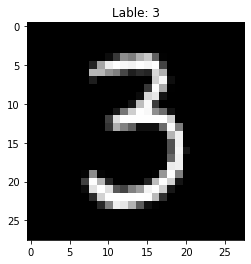

In [4]:
from matplotlib import pyplot as plt
sample_id = 50
plt.imshow(x_train[sample_id], cmap='gray')
plt.title(f'Lable: {y_train[sample_id]}')
plt.show()

## Pre-processing

### Normalize **[15 Points]**
Normalizing the pixel values of the images to the range [0, 1] or [-1, 1] helps to standardize the data and improve the performance of the model.

In [5]:
# TODO: Normalize the data

#Reshaping Data 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) 
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

#Converting data points to float so we can normalize it
x_train = x_train.astype('float32')   
x_test = x_test.astype('float32')

#Normalizing the data between 0 and 1
x_train /= 255                        
x_test /= 255

#Converting the labels into one-hot encoded vector because they are categorical data

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Split the training dataset **[15 Points]**
A common method for ensuring the generalization of the model is to split the training dataset two chucks, **train**, **validation**, and **test**.

In [6]:
# TODO: Split the training set

#Doing a 90:10 split for Train Validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.10)

### Data Augmentation **[Extra 10 Points]**
To increase the size of the training dataset and reduce overfitting, techniques such as random rotations, translations, and flips can be applied to the training images.

In [7]:
# TODO: Perform data augmentation

# For our data augmentation we will Rotation, Shift and Zoom.
datagen = ImageDataGenerator(rotation_range=20, # 20 degree rotation range
                             width_shift_range=0.1, # 1% shift range of the image 
                             height_shift_range=0.1, # 1% shift range of the image
                             zoom_range=0.05)

datagen.fit(x_train)

## Design your model **[20 Points]**
Design a CNN model for the MNIST classification task.

In [34]:
# TODO: Design the architecture of the model

model = keras.Sequential([Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (28 ,28 ,1)),
                          Conv2D(filters = 32, kernel_size = (5,5), activation ='relu'),
                          BatchNormalization(), # To normalize the previous activation
                          Activation('relu'),
                          MaxPool2D(pool_size=(2,2)),
                          Dropout(0.05),

                          Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
                          Conv2D(filters = 64, kernel_size = (5,5), activation ='relu'),
                          BatchNormalization(),
                          Activation('relu'),
                          MaxPool2D(pool_size=(2,2)),
                          Dropout(0.05),

                          Flatten(), # To convert 2D Activations to 1D Activations. Required before using Dense Layers

                          #We will make 3 Dense Layers before the Output Layer
                          Dense(256, activation='relu'),
                          BatchNormalization(),
                          Activation('relu'),

                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Activation('relu'),
                          
                          Dense(84, activation='relu'),
                          BatchNormalization(),
                          Activation('relu'),
                          Dropout(0.05),
                          
                          Dense(10, activation='softmax')
    
])

model.summary()

model.compile(optimizer =RMSprop(learning_rate=1e-4) , loss = "categorical_crossentropy", metrics=["acc"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 32)        25632     
                                                                 
 batch_normalization_10 (Bat  (None, 20, 20, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 20, 20, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 32)       

## Train your model **[20 Points]**
Use the training set to train the model and use the validation set to monitor the traning process. Make sure to use an appropriate loss function considering your task (classification) and model architecure.

In [9]:
# TODO: Fit the model to the traning set

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta =0, patience=6, verbose=1, mode='min',restore_best_weights=True)

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=86),
                              epochs = 15, 
                              validation_data = (x_val,y_val),
                              verbose = 1,
                              steps_per_epoch = x_train.shape[0] // 86,
                              callbacks = [early_stop])


<ipython-input-9-aea8a9231f95>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=86),


Epoch 1/15
627/627 [==============================] - 199s 314ms/step - loss: 1.3549 - acc: 0.5748 - val_loss: 0.7456 - val_acc: 0.9052
Epoch 2/15
627/627 [==============================] - 196s 312ms/step - loss: 0.4219 - acc: 0.8963 - val_loss: 0.1263 - val_acc: 0.9658
Epoch 3/15
627/627 [==============================] - 200s 319ms/step - loss: 0.2358 - acc: 0.9395 - val_loss: 0.1409 - val_acc: 0.9562
Epoch 4/15
627/627 [==============================] - 196s 312ms/step - loss: 0.1703 - acc: 0.9541 - val_loss: 0.0586 - val_acc: 0.9815
Epoch 5/15
627/627 [==============================] - 196s 312ms/step - loss: 0.1369 - acc: 0.9622 - val_loss: 0.0701 - val_acc: 0.9808
Epoch 6/15
627/627 [==============================] - 198s 316ms/step - loss: 0.1174 - acc: 0.9668 - val_loss: 0.0420 - val_acc: 0.9865
Epoch 7/15
627/627 [==============================] - 197s 314ms/step - loss: 0.1060 - acc: 0.9705 - val_loss: 0.0441 - val_acc: 0.9875
Epoch 8/15
627/627 [============================

## Evaluation

### Plot the loss **[15 Points]**
Plot the trend of training loss and validation loss with respect to epochs. You should use visualization libraries (e.g. `matplotlib`, `seaborn`) to show these plots.

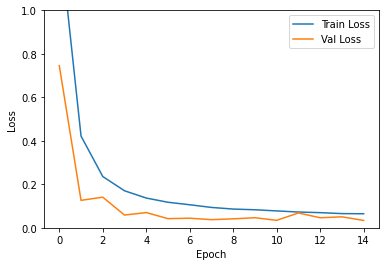

In [10]:
# TODO: Plot training history of the model

hist = pd.DataFrame(history.history)

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.legend()
    plt.ylim([0, 1])

plot_history()

### Test the model on the test set **[15 Points]**
Compute accuracy, F1 macro, precision, and recall scores of the model. You can use functions available in machine learning libraries such as `scikit-learn` to compute these metrics.

In [12]:
# TODO: Model evaluation and metrics

#Using the model to predict our test data
predictions = model.predict(x_test)
loss, accuracy = model.evaluate(x_test, y_test)

print('Accuracy: {}'.format(accuracy))

precision, recall, fscore, support = score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

for i in range(10):
  print('Class {}'.format(i))
  print('precision: {}'.format(precision[i]))
  print('recall: {}'.format(recall[i]))
  print('fscore: {}'.format(fscore[i]))

313/313 [==============================] - 9s 27ms/step - loss: 0.0355 - acc: 0.9905
Accuracy: 0.9904999732971191
Class 0
precision: 0.9949031600407747
recall: 0.9959183673469387
fscore: 0.9954105048444671
Class 1
precision: 0.9972924187725631
recall: 0.973568281938326
fscore: 0.9852875613018279
Class 2
precision: 0.9912875121006777
recall: 0.9922480620155039
fscore: 0.991767554479419
Class 3
precision: 0.9970119521912351
recall: 0.9910891089108911
fscore: 0.9940417080436942
Class 4
precision: 0.9799196787148594
recall: 0.9938900203665988
fscore: 0.9868554095045501
Class 5
precision: 0.9921612541993281
recall: 0.9932735426008968
fscore: 0.9927170868347338
Class 6
precision: 0.9947589098532494
recall: 0.9906054279749478
fscore: 0.9926778242677825
Class 7
precision: 0.9902912621359223
recall: 0.9922178988326849
fscore: 0.9912536443148688
Class 8
precision: 0.9816700610997964
recall: 0.9897330595482546
fscore: 0.9856850715746421
Class 9
precision: 0.985279685966634
recall: 0.9950445986124

### Visualize filters and feature maps **[Extra 20 Points]**
In this section, you will delve into the inner workings of a Convolutional Neural Network (CNN) model by visualizing its feature maps and kernels at each layer. This will provide a deeper understanding of how the model processes input images and recognize patterns.

Tip: To visualize the feature maps, you need to forward-pass an image to the network, extract the activations from the intermediate layers of the network,  and plot them as images. The activations represent the feature maps produced by the filters in the convolutional layers.

0 conv2d_8 (None, 24, 24, 32)
1 conv2d_9 (None, 20, 20, 32)
6 conv2d_10 (None, 6, 6, 64)
7 conv2d_11 (None, 2, 2, 64)
1/1 [==============================] - 0s 50ms/step


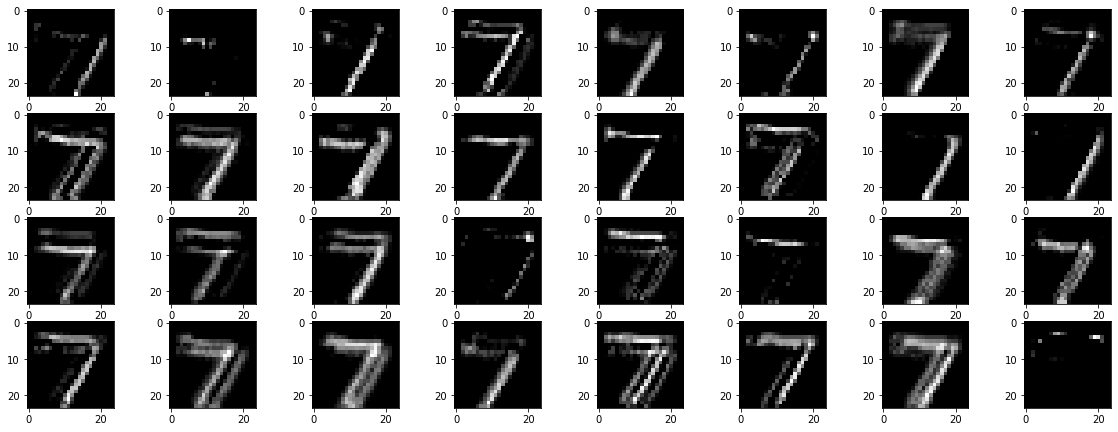

In [36]:
# TODO: Visualize feature maps

# Below will give us an idea on the shape of the feature maps and outputs of each of the convolutionanal layers
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

mod = Model(inputs=model.inputs , outputs=model.layers[0].output)

features = mod.predict(x_test[:1,:,:,:])

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()